<a href="https://colab.research.google.com/github/NahinAlam001/499B/blob/classification/PH2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import os
import cv2
import shutil
import random
import gdown
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from imblearn.over_sampling import SMOTE
from skimage.io import imread
from pathlib import Path
from PIL import Image
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn import functional as F
from torchvision import transforms
from torchvision.transforms import ColorJitter, RandomAffine
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

In [4]:
gdown.download('https://drive.google.com/uc?id=12n80fPYakuYklZ0jv9834cs5iYJJ6pJM', 'image.zip', quiet=False)
with zipfile.ZipFile('image.zip', 'r') as zip_ref:
  zip_ref.extractall()

Downloading...
From (original): https://drive.google.com/uc?id=12n80fPYakuYklZ0jv9834cs5iYJJ6pJM
From (redirected): https://drive.google.com/uc?id=12n80fPYakuYklZ0jv9834cs5iYJJ6pJM&confirm=t&uuid=8443e021-69dd-432b-949f-dea301eefda4
To: /content/image.zip
100%|██████████| 150M/150M [00:07<00:00, 19.5MB/s]


## Takeout the /content/ph2/ph2_dataset_master folder and make it /content/data

In [5]:
data = pd.read_excel('data/PH2_simple_dataset.xlsx')
data.describe()

,image_name,diagnosis
count,200,200
unique,200,3
top,IMD003,Common Nevus
freq,1,80


In [6]:
data_path = 'data/images'
train_path = os.path.join(data_path, 'train')
test_path = os.path.join(data_path, 'test')

os.makedirs(train_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

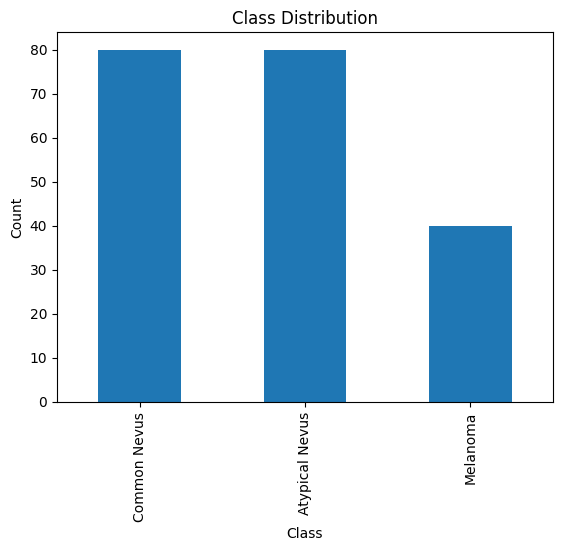

In [7]:
class_distribution = data['diagnosis'].value_counts()
class_distribution.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [8]:
train_data, test_data = train_test_split(data, test_size=0.2, stratify=data['diagnosis'], random_state=42)
len(train_data), len(test_data)

(160, 40)

In [9]:
def move_images(data, destination):
    skipped_count = 0
    for _, row in data.iterrows():
        image_name = row['image_name']
        if not image_name.endswith('.jpg'):
            image_name += '.jpg'
        diagnosis = row['diagnosis']
        source_path = os.path.join(data_path, image_name)
        destination_class_path = os.path.join(destination, diagnosis)
        os.makedirs(destination_class_path, exist_ok=True)
        destination_image_path = os.path.join(destination_class_path, image_name)
        try:
            shutil.move(source_path, destination_image_path)
        except FileNotFoundError:
            print(f"File '{image_name}' not found in directory. Skipping...")
            skipped_count += 1
            continue

    return skipped_count

train_skipped_count = move_images(train_data, train_path)
test_skipped_count = move_images(test_data, test_path)

print(f"Total skipped images in train set: {train_skipped_count}")
print(f"Total skipped images in test set: {test_skipped_count}")

Total skipped images in train set: 0
Total skipped images in test set: 0


In [10]:
def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f'There are {len(dirnames)} folders and {len(filenames)} images in {dirpath}')

walk_through_dir(data_path)

There are 2 folders and 0 images in data/images
There are 3 folders and 0 images in data/images/train
There are 0 folders and 32 images in data/images/train/Melanoma
There are 0 folders and 64 images in data/images/train/Atypical Nevus
There are 0 folders and 64 images in data/images/train/Common Nevus
There are 3 folders and 0 images in data/images/test
There are 0 folders and 8 images in data/images/test/Melanoma
There are 0 folders and 16 images in data/images/test/Atypical Nevus
There are 0 folders and 16 images in data/images/test/Common Nevus


In [18]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.Lambda(lambda x: torch.clamp(x, 0, 1))
])


In [19]:
train_data = ImageFolder(root=train_path,
                      transform=transform,
                      target_transform=None)

test_data = ImageFolder(root=test_path,
                      transform=transform)

In [20]:
BATCH_SIZE = 32

train_dataloader = DataLoader(dataset = train_data,
                              batch_size = BATCH_SIZE,
                              shuffle = True,
                              num_workers = os.cpu_count())

test_dataloader = DataLoader(dataset = test_data,
                              batch_size = BATCH_SIZE,
                              shuffle = False,
                              num_workers = os.cpu_count())

In [21]:
data_path = Path('data')
image_path = data_path/'images'

image_path_list = list(image_path.glob('*/*/*.jpg'))
len(image_path_list)

200

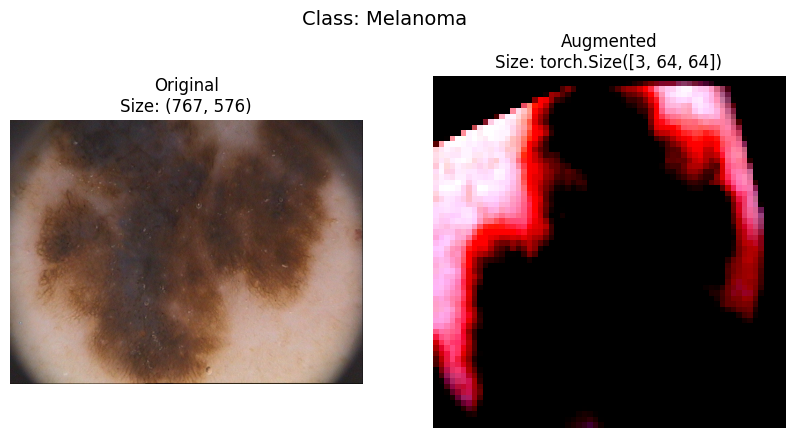

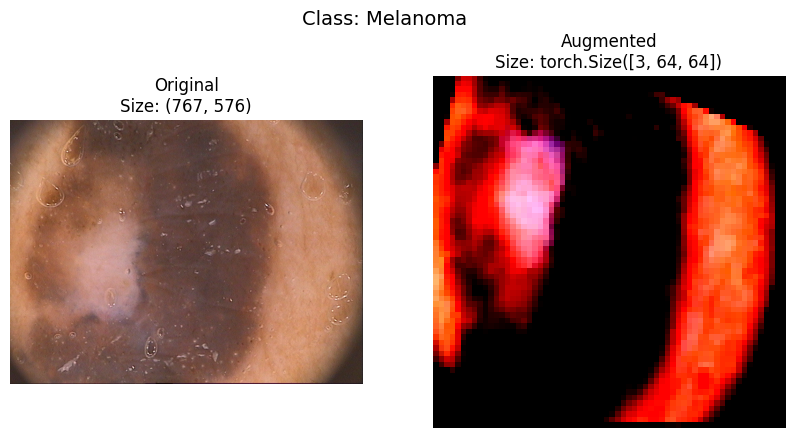

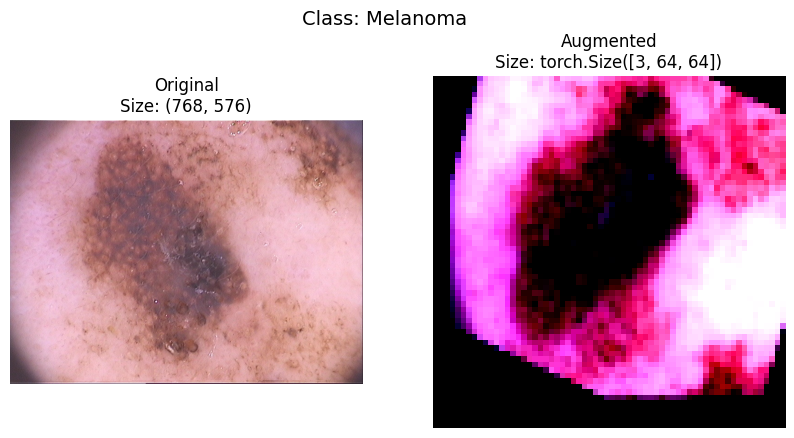

In [22]:
def visualizing(image_paths: list, transform, n=3, seed=None):
    if seed:
        random.seed(seed)

    random_images = random.sample(image_paths, k=n)

    for image_path in random_images:
        with Image.open(image_path) as img:
            fig, axs = plt.subplots(1, 2, figsize=(10, 5))
            fig.suptitle(f'Class: {Path(image_path).parent.stem}', fontsize=14)


            axs[0].imshow(img)
            axs[0].set_title(f'Original\nSize: {img.size}')
            axs[0].axis('off')


            transformed_img = transform(img)


            axs[1].imshow(transformed_img.permute(1, 2, 0))
            axs[1].set_title(f'Augmented\nSize: {transformed_img.shape}')
            axs[1].axis('off')

            plt.show()


visualizing(image_path_list, transform, 3, seed=42)

##CNN

In [23]:
class CNNModel(nn.Module):
  def __init__(self, num_classes):
    super(CNNModel, self).__init__()
    self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding='same')
    self.pool1 = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding='same')
    self.pool2 = nn.MaxPool2d(2, 2)
    self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding='same')
    self.pool3 = nn.MaxPool2d(2, 2)
    self.fc1 = nn.Linear(64 * 8 * 8, 512)
    self.dropout1 = nn.Dropout(p=0.5)
    self.fc2 = nn.Linear(512, num_classes)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.pool1(x)
    x = F.relu(self.conv2(x))
    x = self.pool2(x)
    x = F.relu(self.conv3(x))
    x = self.pool3(x)
    x = x.view(-1, 64 * 8 * 8)
    x = F.relu(self.fc1(x))
    x = self.dropout1(x)
    x = self.fc2(x)
    return x

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNNModel(num_classes=len(train_data.classes)).to(device)

optimizer = Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [25]:
# Training loop
num_epochs = 30
for epoch in range(num_epochs):
    train_loss = 0
    train_acc = 0
    model.train()
    for batch, (data, target) in enumerate(train_dataloader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += (output.argmax(1) == target).sum().item()

    print(f'Epoch: {epoch+1}/{num_epochs} | Train Loss: {train_loss/len(train_data):.4f} | Train Acc: {train_acc/len(train_data):.4f}')

# Testing loop
test_acc = 0
model.eval()
with torch.no_grad():
    for data, target in test_dataloader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        test_acc += (output.argmax(1) == target).sum().item()

print(f'Test Accuracy: {test_acc/len(test_data):.4f}')

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 1/30 | Train Loss: 0.0336 | Train Acc: 0.4000
Epoch: 2/30 | Train Loss: 0.0322 | Train Acc: 0.4562
Epoch: 3/30 | Train Loss: 0.0319 | Train Acc: 0.3625
Epoch: 4/30 | Train Loss: 0.0308 | Train Acc: 0.4250
Epoch: 5/30 | Train Loss: 0.0287 | Train Acc: 0.5375
Epoch: 6/30 | Train Loss: 0.0294 | Train Acc: 0.4688
Epoch: 7/30 | Train Loss: 0.0271 | Train Acc: 0.5625
Epoch: 8/30 | Train Loss: 0.0280 | Train Acc: 0.5500
Epoch: 9/30 | Train Loss: 0.0288 | Train Acc: 0.5375
Epoch: 10/30 | Train Loss: 0.0267 | Train Acc: 0.5938
Epoch: 11/30 | Train Loss: 0.0280 | Train Acc: 0.5625
Epoch: 12/30 | Train Loss: 0.0266 | Train Acc: 0.6438
Epoch: 13/30 | Train Loss: 0.0259 | Train Acc: 0.5938
Epoch: 14/30 | Train Loss: 0.0262 | Train Acc: 0.5813
Epoch: 15/30 | Train Loss: 0.0242 | Train Acc: 0.6500
Epoch: 16/30 | Train Loss: 0.0246 | Train Acc: 0.6312
Epoch: 17/30 | Train Loss: 0.0254 | Train Acc: 0.6562
Epoch: 18/30 | Train Loss: 0.0261 | Train Acc: 0.6000
Epoch: 19/30 | Train Loss: 0.0266 | T

## Let's try DenseNet